#Importing Libraries

In [ ]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2
import os
from random import shuffle
from tqdm import tqdm
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

#Mounting Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading saved data and labels

In [ ]:
y_train = np.load("/content/drive/My Drive/Datasets/Skin_npy/y_train.npy")
x_train = np.load("/content/drive/My Drive/Datasets/Skin_npy/x_train.npy")
x_test = np.load("/content/drive/My Drive/Datasets/Skin_npy/x_validate.npy")
y_test = np.load("/content/drive/My Drive/Datasets/Skin_npy/y_validate.npy")

In [ ]:
x_train.shape

(7210, 80, 100, 3)

## Image Data Normalization

In [ ]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by dividing 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [ ]:
y_train=to_categorical(y_train,7)
y_test=to_categorical(y_test,7)

## Image Augmentation

In [ ]:
trainAug  = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

## Model Building

In [ ]:
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [ ]:
callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
BS = 64
print("[INFO] training head...")
H = model.fit(
	trainAug.flow(x_train,y_train, batch_size=BS),
	steps_per_epoch=train_len // BS,
	validation_data=(x_test, y_test),
	validation_steps=test_len // BS,
	epochs=30,callbacks=callbacks)

[INFO] training head...
Epoch 1/30
46/46 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7899
Epoch 1: val_loss improved from inf to 9.99396, saving model to .mdl_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 79s 961ms/step - loss: 0.5459 - accuracy: 0.7899 - val_loss: 9.9940 - val_accuracy: 0.3662 - lr: 0.0010
Epoch 2/30
46/46 [==============================] - ETA: 0s - loss: 0.3707 - accuracy: 0.8641
Epoch 2: val_loss improved from 9.99396 to 8.57934, saving model to .mdl_wts.hdf5
46/46 [==============================] - 39s 851ms/step - loss: 0.3707 - accuracy: 0.8641 - val_loss: 8.5793 - val_accuracy: 0.3676 - lr: 0.0010
Epoch 3/30
46/46 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.8844
Epoch 3: val_loss did not improve from 8.57934
46/46 [==============================] - 39s 837ms/step - loss: 0.3353 - accuracy: 0.8844 - val_loss: 9.5384 - val_accuracy: 0.3662 - lr: 0.0010
Epoch 4/30
46/46 [==============================] - ETA: 0s - loss: 0.2579 - accuracy: 0.9048
Epoch 4: val_loss did not improve from 8.57934

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
46/46 [=======================

## Saving and Loading Model

In [ ]:
model = load_model('.mdl_wts.hdf5')
model.save('/content/drive/My Drive/skin_model/model_v2.h5')


In [ ]:
model = load_model('/content/drive/My Drive/skin_model/model_v2.h5')

va

In [ ]:
feats_test=np.load("/content/drive/My Drive/skin_cancer_dataset/feats_test.npy")
labels_test=np.load("/content/drive/My Drive/skin_cancer_dataset/labels_test.npy")

num_classes=len(np.unique(labels_test))
len_data=len(feats_test)
print(len_data)

155


In [ ]:
x_test = feats_test.astype('float32')/255
y_test=to_categorical(labels_test,3)

16/16 [==============================] - 6s 385ms/step


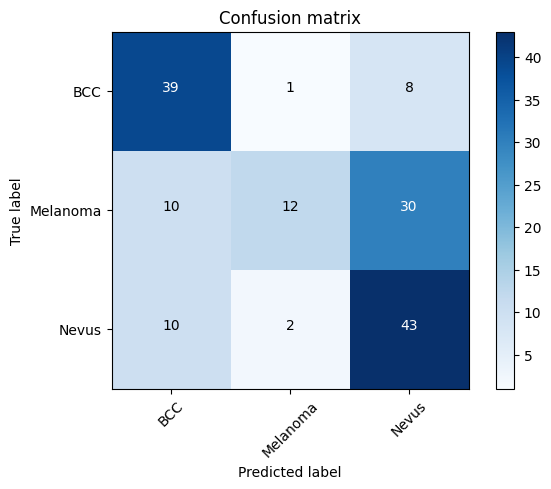

In [ ]:
pred_Y = model.predict(x_valid, batch_size = 10, verbose = True)
rounded_predictions = model.predict(x_valid, batch_size=16, verbose=0)
pred = np.argmax(rounded_predictions,axis=1)
rounded_labels=np.argmax(y_valid, axis=1)
BS=10
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['BCC','Melanoma','Nevus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_valid, batch_size=BS)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred_Y,axis=1)
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_valid, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [ ]:
# checking the accuracy
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

5/5 [==============================] - 13s 2s/step - loss: 3.9523 - accuracy: 0.6065

 Test_Accuracy:- 0.6064516305923462


In [ ]:
rounded_predictions = model.predict(x_test, batch_size=16, verbose=0)
rounded_predictions[1]

array([1.8938366e-01, 8.1061637e-01, 2.7774105e-08], dtype=float32)

In [ ]:
predIdxs = model.predict(x_test, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
rounded_labels=np.argmax(y_test, axis=1)

# show a nicely formatted classification report
print(classification_report(rounded_labels, predIdxs,target_names=['BCC','Melanoma','Nevus']))

10/10 [==============================] - 5s 481ms/step
              precision    recall  f1-score   support

         BCC       0.66      0.81      0.73        48
    Melanoma       0.80      0.23      0.36        52
       Nevus       0.53      0.78      0.63        55

    accuracy                           0.61       155
   macro avg       0.66      0.61      0.57       155
weighted avg       0.66      0.61      0.57       155



Text(0.5, 1.0, 'Training and validation loss')

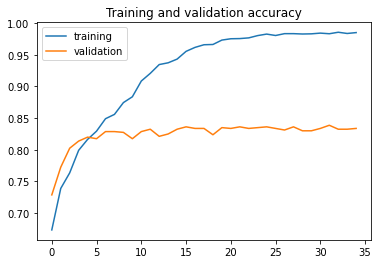

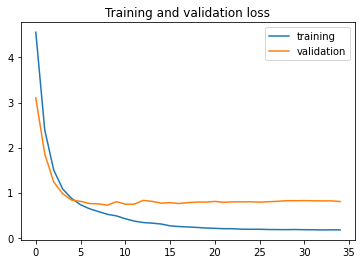

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

10/10 [==============================] - 8s 738ms/step


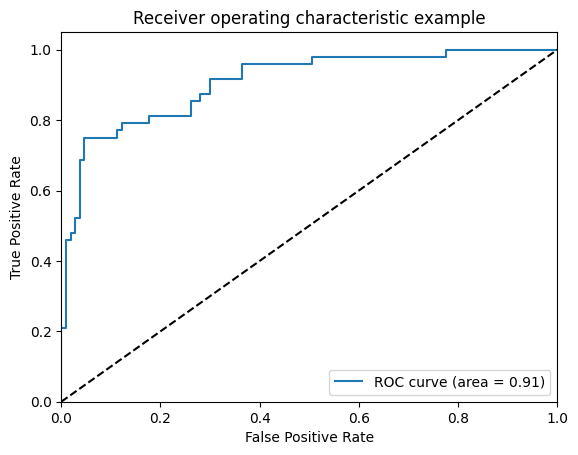

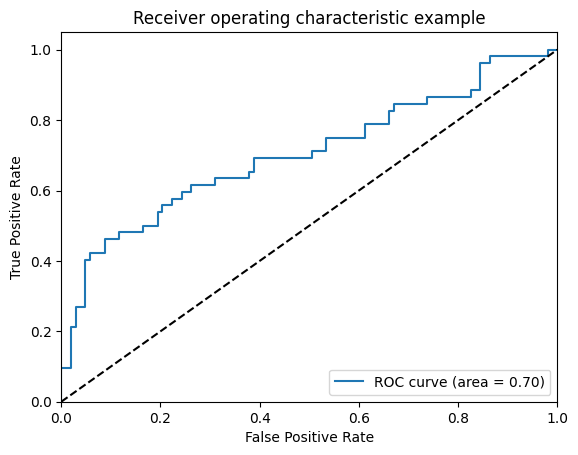

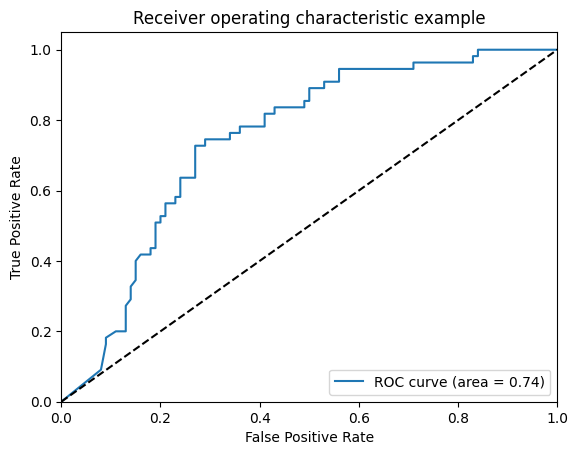

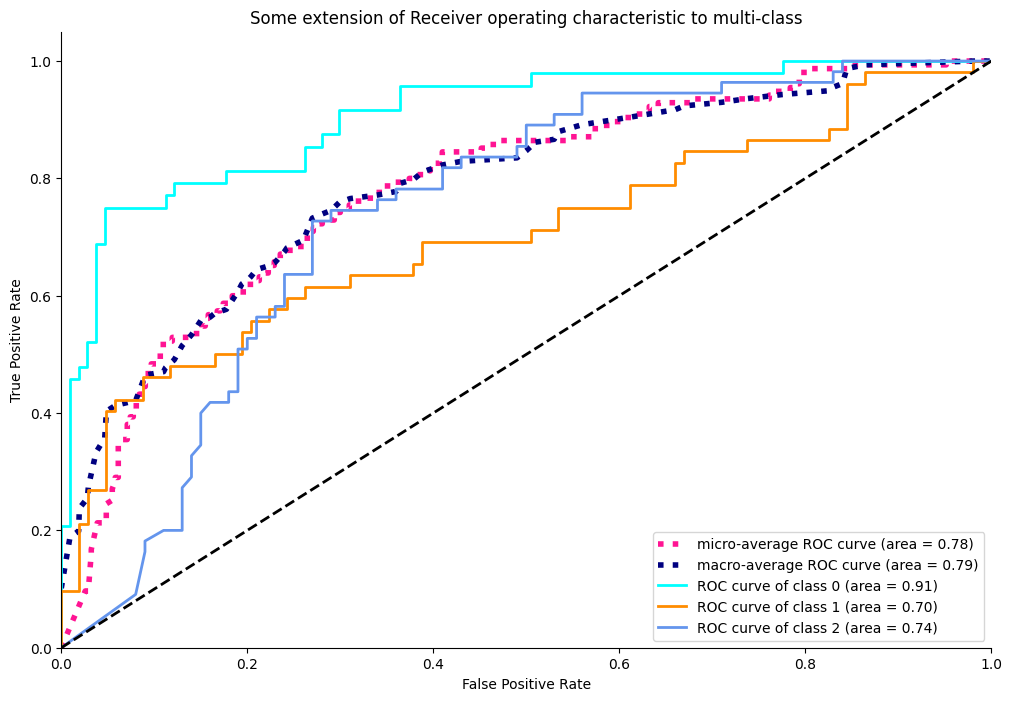

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


y_test = np.array(y_test)

n_classes = 3

pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

## Preparing Test Data

In [ ]:
data=[]
labels=[]
Basal=os.listdir("/content/drive/My Drive/skin_cancer_dataset/Basal_cell_carcinoma/test/")
for a in Basal:
    try:
        image=cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Basal_cell_carcinoma/test/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Melanoma=os.listdir("/content/drive/My Drive/skin_cancer_dataset/Melanoma/test/")
for b in Melanoma:
    try:
        image=cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Melanoma/test/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
Nevus=os.listdir("/content/drive/My Drive/skin_cancer_dataset/Nevus/test/")
for c in Nevus:
    try:
        image=cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Nevus/test/"+c)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(2)
    except AttributeError:
        print("")

In [ ]:
feats_test=np.array(data)
labels_test=np.array(labels)

np.save("/content/drive/My Drive/skin_cancer_dataset/feats_test",feats_test)
np.save("/content/drive/My Drive/skin_cancer_dataset/labels_test",labels_test)

In [ ]:
feats_test=np.load("/content/drive/My Drive/skin_cancer_dataset/feats_test.npy")
labels_test=np.load("/content/drive/My Drive/skin_cancer_dataset/labels_test.npy")

num_classes=len(np.unique(labels_test))
len_data=len(feats_test)
print(len_data)

155


In [ ]:
x_test = feats_test.astype('float32')/255
y_test=to_categorical(labels_test,3)

16/16 [==============================] - 4s 274ms/step


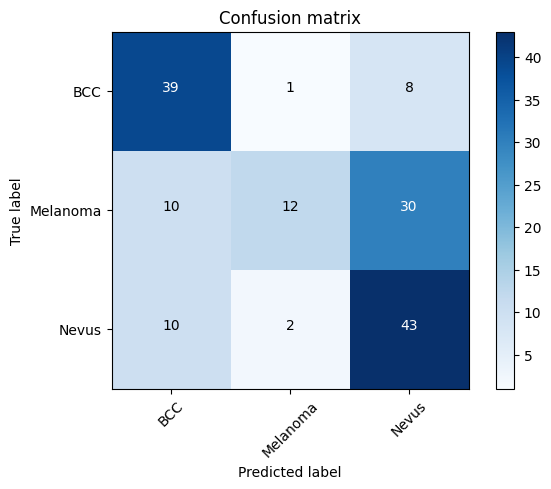

In [ ]:
pred_Y = model.predict(x_valid, batch_size = 10, verbose = True)
rounded_predictions = model.predict(x_valid, batch_size=16, verbose=0)
pred = np.argmax(rounded_predictions,axis=1)
rounded_labels=np.argmax(y_valid, axis=1)
BS=10
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['BCC','Melanoma','Nevus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_valid, batch_size=BS)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred_Y,axis=1)
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_valid, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [ ]:
model = load_model('/content/drive/My Drive/skin_model/model_v1.h5')

In [ ]:
img1 = "/content/drive/MyDrive/skin_cancer_dataset/Nevus/test/nv_ISIC_0000075.jpg"
img2 ="/content/drive/MyDrive/skin_cancer_dataset/Melanoma/test/mel_ISIC_0000302.jpg"
img3 = "/content/drive/MyDrive/skin_cancer_dataset/Melanoma/test/mel_ISIC_0010267.jpg"

In [ ]:
class_dict ={0:"Basal_Cell_Carcinoma (Cancer)",
             1:"Melanoma (Cancer)",
             2:"Nevus (Non-Cancerous)"}

In [ ]:
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  #img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255

  preds = model.predict(img)[0]
  prediction = sorted(
      [(class_dict[i], round(j*100, 2)) for i, j in enumerate(preds)],
      reverse=True,
      key=lambda x: x[1]
  )

  return prediction

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
from IPython.display import  display
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255

  preds = model.predict(img)
  pred = np.argmax(preds,axis = 1)
  print(pred)
  #pred_cat = [k for k, v in class_dict.items() if v == pred[0]][0]

  return pred

In [ ]:
class_dict[np.argmax(pred_image(img1,model))]
#np.argmax(pred_image(img1,model))

1/1 [==============================] - 0s 93ms/step
[1]
1/1 [==============================] - 0s 108ms/step
[1]


0

In [ ]:
class_dict[np.argmax(pred_image(img2,model))]

1/1 [==============================] - 0s 54ms/step
[1]


'Basal_Cell_Carcinoma (Cancer)'

In [ ]:
class_dict[np.argmax(pred_image(img3,model))]

1/1 [==============================] - 0s 58ms/step
[0]


'Basal_Cell_Carcinoma (Cancer)'

# Plotting Sample Predictions

5/5 [==============================] - 14s 2s/step


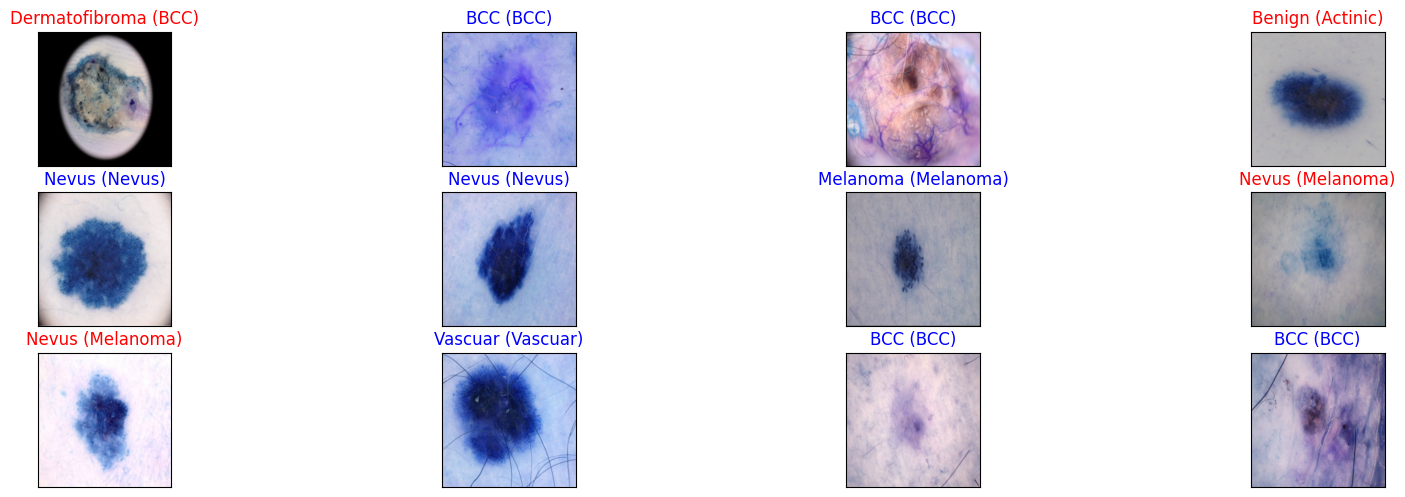

In [ ]:
y_hat = model.predict(x_test)

# define text labels
skin_labels = ['BCC','Melanoma','Nevus','Benign','Actinic','Vascuar','Dermatofibroma','BCC','Melanoma']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    if i%3:
      ax.set_title("{} ({})".format(skin_labels[pred_idx], skin_labels[true_idx]),
                  color=("blue" if pred_idx == true_idx else "red"))
    elif i%2:
      ax.set_title("{} ({})".format(skin_labels[pred_idx+3], skin_labels[true_idx+3]),
                  color=("blue" if pred_idx == true_idx else "red"))
    else:
      ax.set_title("{} ({})".format(skin_labels[pred_idx+6], skin_labels[true_idx+6]),
                  color=("blue" if pred_idx == true_idx else "red"))